In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from tensorflow.keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

## build U-net model

In [4]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [5]:
# from keras.utils import normalize
import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#initialize directory
#store the list directory in a variable 
#directory for pictures
os.chdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/images')
list_pic   = os.listdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/images')
print(len(list_pic))

800


In [7]:
print(len(list_pic))

800


In [8]:
#directory for mask
os.chdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/masks')
list_mask   = os.listdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/masks')
print(len(list_mask))

704


In [9]:
print(len(list_mask))

704


In [30]:
#store in list and only take 400 for images
list_image = []
for filename in list_pic:
   if filename.endswith('.png'):
       list_image.append(filename)
    

list_image.sort()
list_image = list_image[:10]
len(list_image)

10

In [29]:
#store in list and only take 400 for images
list_masks = []
for filename in list_mask:
   if not filename.startswith('._'):
       list_masks.append(filename)
    

list_masks.sort()
list_masks = list_masks[:10]
len(list_masks)

10

## preprocessing

crop into patches

In [28]:
from patchify import patchify

In [12]:
for img in range(len(list_image)):

    image = cv2.imread("C:/Users/zamfirdaus/Desktop/VIP/dataset/images/" + list_image[img], 1)            
       
    #Extract patches from each image
    print("Now patchifying image:", "C:/Users/zamfirdaus/Desktop/VIP/dataset/images/"+list_image[img])
    patches_img = patchify(image, (512, 512, 3), step=512) 
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.    
            cv2.imwrite('C:/Users/zamfirdaus/Desktop/VIP/dataset/imagesPatches/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".PNG", single_patch_img)

Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0001_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0002_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0003_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0004_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0005_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0006_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0007_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0008_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0009_0.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/images/CHNCXR_0010_0.png


In [13]:
for m in range(len(list_masks)):

    mask = cv2.imread("C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/" + list_masks[m], 1)               
    
    #Extract patches from each image
    print("Now patchifying image:", "C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/"+list_masks[m])
    patches_mask = patchify(mask, (512, 512, 3), step=512) 
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.    
            cv2.imwrite('C:/Users/zamfirdaus/Desktop/VIP/dataset/masksPatches/' + 'image_' + str(m) + '_' + str(i)+str(j)+ ".PNG", single_patch_mask)

Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0001_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0002_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0003_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0004_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0005_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0006_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0007_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0008_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0009_0_mask.png
Now patchifying image: C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/CHNCXR_0010_0_mask.png


In [31]:
#store new images in list
os.chdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/imagesPatches')
images_ds   = os.listdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/imagesPatches')
print(len(images_ds))

236


In [32]:
os.chdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/masksPatches')
masks_ds   = os.listdir('C:/Users/zamfirdaus/Desktop/VIP/dataset/masksPatches')
print(len(masks_ds))

236


In [33]:
print(len(images_ds))


236


In [34]:
print(len(masks_ds))

236


In [35]:
from tqdm.notebook import tqdm


#initialize size
SIZE = 512
#load image and mask into array
X = np.zeros((1185, SIZE, SIZE, 1), dtype=np.float32)
y = np.zeros((1185, SIZE, SIZE, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(images_ds), total=len(images_ds)):
    # Load images
    img = load_img("C:/Users/zamfirdaus/Desktop/VIP/dataset/imagesPatches/"+id_, grayscale=True)
    x_img = img_to_array(img)
    # Load masks
    y_mask = img_to_array(load_img("C:/Users/zamfirdaus/Desktop/VIP/dataset/masksPatches/"+masks_ds[n], grayscale=True))
    # Save images
    X[n] = x_img
    y[n] = y_mask

  0%|          | 0/236 [00:00<?, ?it/s]

In [25]:
from tqdm.notebook import tqdm


#initialize size
SIZE = 512
#load image and mask into array
X = np.zeros((700, SIZE, SIZE, 1), dtype=np.float32)
y = np.zeros((700, SIZE, SIZE, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(list_image), total=len(list_image)):
    # Load images
    img = load_img("C:/Users/zamfirdaus/Desktop/VIP/dataset/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = x_img.reshape(512,512,1)
    # Load masks
    y_mask = img_to_array(load_img("C:/Users/zamfirdaus/Desktop/VIP/dataset/masks/"+list_masks[n], grayscale=True))
    y_mask = y_mask.reshape(512,512,1)
    # Save images
    X[n] = x_img
    y[n] = y_mask

  0%|          | 0/700 [00:00<?, ?it/s]

C:\Users\zamfirdaus\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


ValueError: cannot reshape array of size 8757000 into shape (512,512,1)

In [19]:
y.shape

(1185, 512, 512, 1)

In [36]:
import keras
# from keras.utils.conv_utils import normalize
from keras.utils.conv_utils import normalize_data_format


#Normalize images
image_dataset = np.expand_dims(tf.keras.utils.normalize(np.array(X), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(y)),3) /255.

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

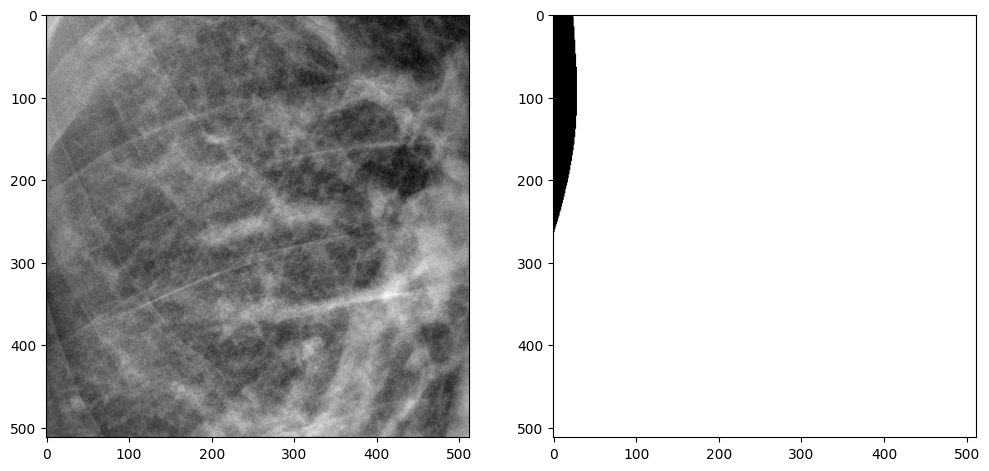

In [45]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

## Training

In [46]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [47]:
IMG_CHANNELS

1

In [25]:
# model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [48]:
import segmentation_models as sm
model = sm.Unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), encoder_weights=None)
model.compile(
    'Adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Segmentation Models: using `keras` framework.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
________________________________________________

In [49]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('C:/Users/zamfirdaus/Desktop/VIP/model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [50]:
results = model.fit(X_train, y_train, batch_size=16, epochs=1, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

67/67 [==============================] - 3158s 47s/step - loss: 0.4559 - accuracy: 0.8264 - val_loss: 0.5324 - val_accuracy: 0.9398

Epoch 00001: val_loss improved from inf to 0.53240, saving model to C:/Users/zamfirdaus/Desktop/VIP\model.h5


In [51]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

4/4 [==============================] - 84s 21s/step - loss: 0.5324 - accuracy: 0.9398
Accuracy =  93.98088455200195 %


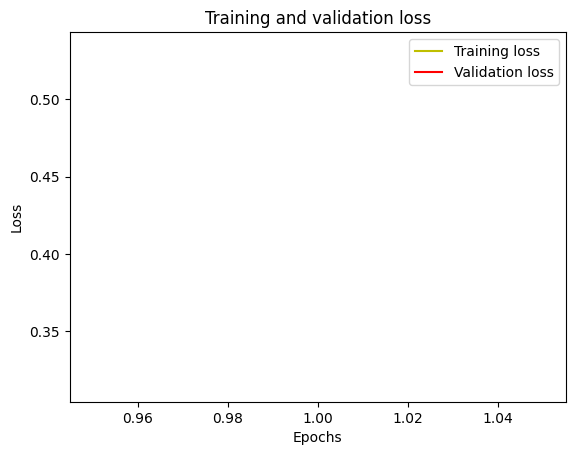

In [65]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
results.history

{'loss': [0.3154118061065674],
 'accuracy': [0.9042738676071167],
 'val_loss': [0.5324043035507202],
 'val_accuracy': [0.9398086667060852],
 'lr': [0.001]}

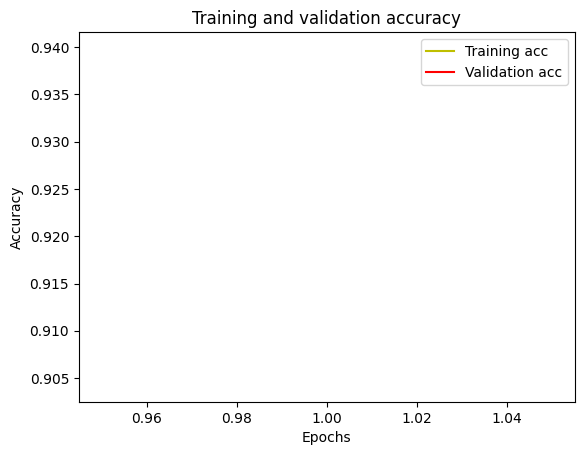

In [53]:
#acc = results.history['acc']
acc = results.history['accuracy']
#val_acc = results.history['val_acc']
val_acc = results.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
#y_pred=model.predict(X_test)
#y_pred_thresholded = y_pred > 0.5

#intersection = np.logical_and(y_test, y_pred_thresholded)
#union = np.logical_or(y_test, y_pred_thresholded)
#iou_score = np.sum(intersection) / np.sum(union)
#print("IoU socre is: ", iou_score)

In [54]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

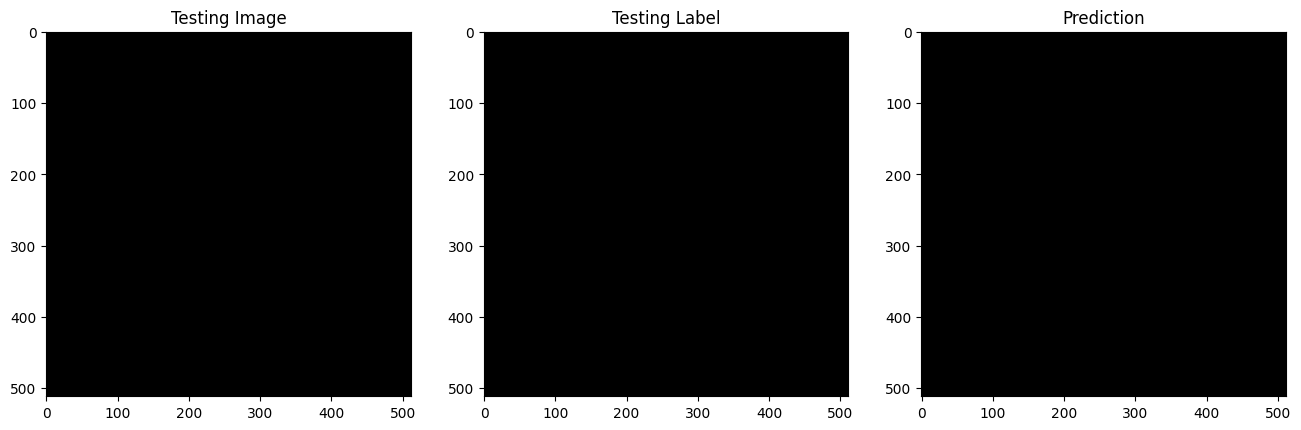

In [58]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(133)
plt.title('Prediction')
plt.imshow(prediction, cmap='gray')
plt.show()

In [ ]:
# Predict on train, val and test
#preds_train = model.predict(X_train, verbose=1)
#preds_val = model.predict(X_test, verbose=1)

In [59]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

NameError: name 'preds_train' is not defined